In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.size'] = 13
plt.rcParams['axes.spines.right'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.top'] = False

### What kind of stimulus causes a cell to fire?

In [113]:
# Generate an example filter
dt = 0.01
freq = 8
tau = 0.05
t = np.arange(-0.25, 0+dt, dt)
f = -np.sin(2*np.pi*freq*t)*np.exp(t/tau)
f = f / np.linalg.norm(f)
#plt.plot(t, f, 'k-')

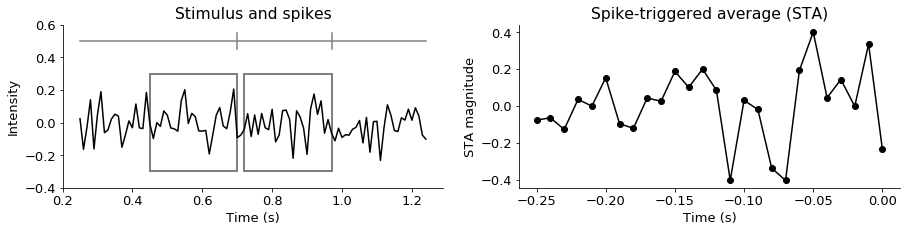

In [174]:
np.random.seed(13)
l = 1000;      # stimulus length in seconds
nPlot = 100; # samples to plot
winSize = 0.25 # filter size (s)
shift = 25     # shift to avoid negative indices

# Simulate data
time = np.arange(0, l/dt+dt, dt)                # time stamps
s = 0.1*np.random.randn(int(l/dt));             # white noise stimulus
z = np.convolve(s, np.flip(f, axis=0), 'full')  # 1. convolve with the flipped filter
mu = z * (z>0)                                  # 2. rectifying non-linearity
spikes = np.random.poisson(mu)                  # 3. spike generation

# plot the stimulus, spikes, and the window containing the stimulus preceeding each spike
plt.figure(figsize=(15, 3))
ah = plt.subplot(1, 2, 1)
plt.plot(time[shift:nPlot+shift], s[shift:nPlot+shift], 'k-')
ah.set_ylabel('Intensity')
ah.set_xlabel('Time (s)')
ah.set_title('Stimulus and spikes')
ah.set_ylim([-0.4, 0.6])
plt.plot(time[shift:nPlot+shift], 0.5*np.ones(nPlot), '-', color='gray')
for idx in np.argwhere(spikes[shift:nPlot+shift]>0):
    plt.plot([time[idx+shift], time[idx+shift]], [0.45, 0.55], '-', color='gray')
    rect = patches.Rectangle([time[idx+shift]-winSize, -0.3], winSize, 0.6, linewidth=2,edgecolor='gray',facecolor='none')
    ah.add_patch(rect)
    
# Calculate and plot the spike-triggered average (STA)
ah = plt.subplot(1, 2, 2)
nSta = int(winSize/dt)+1;
sta = np.zeros(nSta)
for idx in np.argwhere(spikes[shift:nPlot+shift]>0):
    sta += spikes[shift+idx]*s[idx[0]+shift-nSta+1:idx[0]+shift+1]
staNorm = sta / np.linalg.norm(sta)
plt.plot(np.arange(-winSize, 0+dt, dt), staNorm, 'ko-')
#plt.plot(t, f, '-', color='gray')
ah.set_ylabel('STA magnitude')
ah.set_xlabel('Time (s)')
ah.set_title('Spike-triggered average (STA)');

The STA is the average stimulus that preceded a spike, and consequently, the x-axis has negative time values with time zero (the occurrence of a spike) located in the right most part of the plot. The STA thus tells us what the average stimulus looks like that preceded a spike, and it should therefore not be confused with peri-stimulus time histograms (PSTHs) which represent cell responses to a fixed stimulus.

### What about the LN model?

The linear-nonlinear (LN) model assumes that a cell's behavior, its stimulus-response mapping, can be described using a cascade of a linear operation and a nonlinear function. The linear operation, an inner product between a filter ($\mathbf{w}$) and the stimulus ($\mathbf{x}$), results in a similarity score ($z$) that is transformed into a mean firing rate ($y$) by the nonlinear function ($f$). Mathematically, this is expressed as:

\begin{equation}
 y = f(\mathbf{w}^T\mathbf{x}) = f \left( \sum_j w_j x_j \right).
\end{equation}

If needed, it is also possible to generate realizations of example spike trains by sampling from a spike event distribution, usually a Poisson distribution, with the mean rate $y$. In the end, it is then possible to describe the full LN model as a three step procedure:
1. Calculate the inner product between the filter and each stimulus, or equivalently to filter the stimulus sequence using the filter.
2. Pass the resulting similarity score at each time point through the nonlinearity so as to obtain a firing rate.
3. Draw samples from the event rate distribution to get a realization of a spike train.

These three steps are illustrated below using an example with an oscillating stimulus.

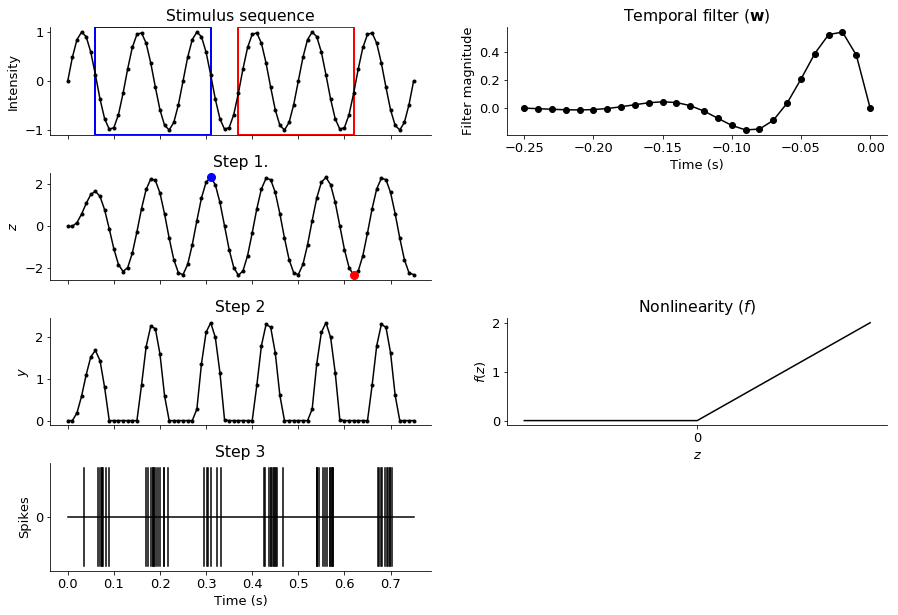

In [169]:
tMax = 0.75;
time = np.arange(0, tMax+dt, dt)
tIdx = 31
nonlin = lambda(z): z * (z>0)
#nonlin = lambda(z): (z/2)**2
s = np.sin(2*np.pi*freq*time)                             # generate an oscillating stimulus
z = np.convolve(s, np.flip(f, axis=0), 'full')[0:s.size]  # 1. filter the stimulus sequence using the LN model's filter
y = nonlin(z)                                             # 2. apply the nonlinearity
spikeCounts = np.random.poisson(y)                        # 3. sample spike counts

fig = plt.figure(figsize=(15, 10))
ah = plt.subplot(4, 2, 1)
plt.plot(time, s, 'k.-')
rect = patches.Rectangle([time[tIdx]-winSize, -1.1], winSize, 2.2, linewidth=2,edgecolor='b',facecolor='none')
ah.add_patch(rect)
rect = patches.Rectangle([time[tIdx+31]-winSize, -1.1], winSize, 2.2, linewidth=2,edgecolor='r',facecolor='none')
ah.add_patch(rect)
ah.set_xticklabels([])
ah.set_ylabel('Intensity')
ah.set_title('Stimulus sequence')

ah = plt.subplot(4, 2, 2)
plt.plot(t, f, 'ko-')
ah.set_ylabel('Filter magnitude')
ah.set_xlabel('Time (s)')
ah.set_title('Temporal filter ($\mathbf{w}$)');

ah = plt.subplot(4, 2, 3)
plt.plot(time, z, 'k.-')
plt.plot(time[tIdx], z[tIdx], 'bo', ms=8)
plt.plot(time[tIdx+31], z[tIdx+31], 'ro', ms=8)
ah.set_xticklabels([])
ah.set_ylabel('$z$')
ah.set_title('Step 1.')

ah = plt.subplot(4, 2, 5)
plt.plot(time, y, 'k.-')
ah.set_xticklabels([])
ah.set_ylabel('$y$')
ah.set_title('Step 2')

ah = plt.subplot(4, 2, 6)
zVals = np.linspace(-2, 2, 101)
plt.plot(zVals, nonlin(zVals), 'k-')
ah.set_xticks([0])
ah.set_xlabel('$z$')
ah.set_ylabel('$f(z)$')
ah.set_title('Nonlinearity ($f$)')

ah = plt.subplot(4, 2, 7)
plt.plot(time, np.zeros(time.size), 'k-')
for count, tt in zip(spikeCounts, time):
    for spike in np.arange(count):
        r = np.random.rand(1)*dt
        plt.plot([tt+r, tt+r], [-0.1, 0.1], 'k-')
ah.set_yticks([0])
ah.set_xlabel('Time (s)')
ah.set_ylabel('Spikes')
ah.set_title('Step 3')

fig.subplots_adjust(hspace=0.35)

### How do you estimate an LN model from data?

The STA will provide the LN model's temporal filter whenever a white noise stimulus is used. For other stimuli, one will either have to fix the nonlinearity beforehand or give up the idea of having a convex optimization problem. In the first case, the nonlinearity is usually fixed to be the identity function or a exponential function, in which case the temporal filter is found by using vanilla linear or Poisson regression, respectively. In the second case, it is possible to find the temporal filter by solving a non-convex optimiation problem which tries to maximize the mutual information between the similarity score and the stimulus. It is thus a bit more work to estimate the LN model for non-white stimuli, and one will have to make a sacrifice by either fixing the nonlinearity or by moving over to solving a non-convex optimization problem.

### Why is the temporal filter sometimes flipped?

Occasionally you may notice that people present temporal filters that are mirrored or flipped, that is, the filter has been flipped along the time dimension as illustrated below.

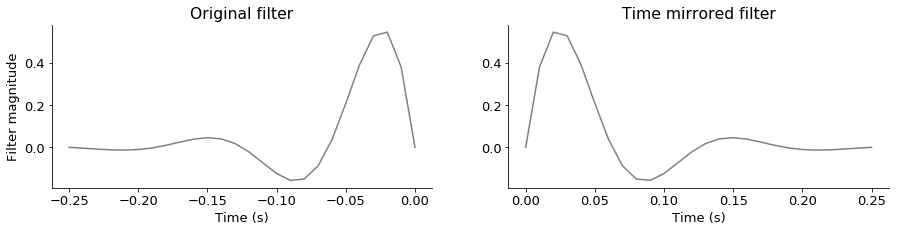

In [168]:
# plot the stimulus, spikes, and the window containing the stimulus preceeding each spike
plt.figure(figsize=(15, 3))
ah = plt.subplot(1, 2, 1)
plt.plot(t, f, '-', color='gray')
ah.set_ylabel('Filter magnitude')
ah.set_xlabel('Time (s)')
ah.set_title('Original filter');
ah = plt.subplot(1, 2, 2)
plt.plot(-1*t, f, '-', color='gray')
ah.set_xlabel('Time (s)')
ah.set_title('Time mirrored filter');

At first glance this might seem a bit odd, as the mirrored filter no longer represents the stimulus that obtains the highest similarity score. However, this way of describing filters derives from the study of linear time-invariant (LTI) systems, where the mirrored filter corresponds to the impulse response. That is, if a cell is linear (or nearly so), then the mirrored filter will describe the response (PSTH) to a brief flash. So, while the original filter describes one point in the stimulus space, the mirrored filter actually describes a cell's response. The original and mirrored filter thus describe very different things and should not be confused with each other, despite their similarity.

Even if you might see filters presented in both ways, my experience is that people tend to use the original way when dealing with LN models. This is also expected, as the presence of the nonlinearity means that the mirrored filter no longer correspond to the impulse response in general (it might still be very close to be impulse response if the system mainly operates in a linear region).